In [45]:
using Revise
using ITensors,ITensorMPS
using PastaQ
push!(LOAD_PATH,"../src/")
using RandomMeas
using ProgressBars

In [46]:
N  = 10
χ = 2^(N÷2)
ξ = siteinds("Qubit", N)
ψ = random_mps(ξ; linkdims=χ);

In [47]:
NAmax = N÷2
nmax = 3
p = zeros(NAmax,nmax-1)
C3 = zeros(NAmax)
r2 = zeros(NAmax)
ITensors.disable_warn_order()
for NA in 1:NAmax
    NAB = 2*NA
    ρT,ξAB = reduce_dm(ψ,1,NAB)
    ρT = flatten(ρT)
    for i in 1:NA
        ρT  = swapind(ρT,ξAB[i],ξAB[i]')
    end
    D, U = eigen(ρT, ξAB, ξAB')
    for k in 1:nmax-1
        for s in 1:dim(D,1)
            p[NA,k] += D[s,s]^(k+1)
        end
    end
    @show NA
    C3[NA] = p[NA,1]^2/p[NA,2]
end

NA = 1
NA = 2
NA = 3
NA = 4
NA = 5


In [48]:
#Perform Randomized measurements
nu=2000
NM=100
data = zeros(Int8,(nu,NM,N))
datat = zeros(Int8,(NM,N))
u = Vector{Vector{ITensor}}()
for r in ProgressBar(1:nu, printing_delay=2)
    push!(u,get_rotations(ξ,1)) #Haar rotations in A
    get_RandomMeas!(datat,ψ,u[r])
    data[r,:,:] = datat[:,:]
end

0.0%┣                                             ┫ 0/2.0k [00:00<00:00, -0s/it]
0.9%┣▍                                            ┫ 17/2.0k [00:02<04:09, 8it/s]
2.5%┣█▏                                          ┫ 51/2.0k [00:04<02:37, 12it/s]
4.2%┣█▉                                          ┫ 85/2.0k [00:06<02:18, 14it/s]
5.9%┣██▌                                        ┫ 117/2.0k [00:08<02:12, 14it/s]
7.6%┣███▎                                       ┫ 152/2.0k [00:10<02:04, 15it/s]
9.2%┣████                                       ┫ 184/2.0k [00:12<02:01, 15it/s]
10.9%┣████▋                                     ┫ 219/2.0k [00:14<01:56, 15it/s]
12.7%┣█████▍                                    ┫ 254/2.0k [00:16<01:52, 16it/s]
14.5%┣██████                                    ┫ 290/2.0k [00:18<01:48, 16it/s]
16.2%┣██████▉                                   ┫ 324/2.0k [00:20<01:45, 16it/s]
17.9%┣███████▌                                  ┫ 359/2.0k [00:22<01:42, 16it/s]
19.6%┣████████▎             

In [49]:
C3s = zeros(NAmax)
for NA in ProgressBar(1:NAmax, printing_delay=2)
    NAB = 2*NA
    uAB = [ut[1:NAB] for ut in u]
    ξAB = ξ[1:NAB]
    #@show NA
    ρs = acquire_shadows_batch_fromdata(data[:,:,1:NAB],ξAB,uAB,nmax)
    for n in 1:nmax
        for i in 1:NA
             ρs[n] = swapind(ρs[n],ξAB[i],ξAB[i]')
        end
    end
    p = get_moments_shadows_batch(ρs, ξAB, nmax, nu)
    #@show p
    C3s[NA] = p[1]^2/p[2]
end

0.0%┣                                                ┫ 0/5 [00:00<00:00, -0s/it]
60.0%┣████████████████████████████▉                   ┫ 3/5 [00:02<00:02, 1s/it]
80.0%┣██████████████████████████████████████▍         ┫ 4/5 [00:14<00:05, 5s/it]
100.0%┣██████████████████████████████████████████████┫ 5/5 [03:15<00:00, 49s/it]
100.0%┣██████████████████████████████████████████████┫ 5/5 [03:15<00:00, 49s/it]


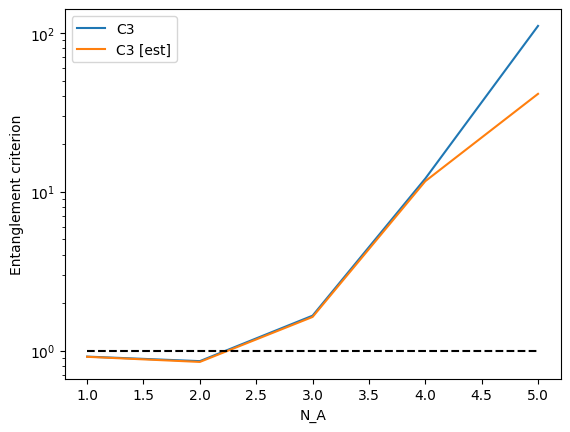

PyObject <matplotlib.legend.Legend object at 0x7f734dd0e1d0>

In [50]:
using PyPlot
PyPlot.plot(1:NAmax,C3,label="C3")
PyPlot.plot(1:NAmax,C3s,label="C3 [est]")
PyPlot.plot(1:NAmax,ones(NAmax),"--k")
xlabel("N_A")
yscale("log")
ylabel("Entanglement criterion")
legend()